<a href="https://colab.research.google.com/github/raulbenitez/NEUROIMAGING_AI/blob/main/NI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 4.8 MB/s 


In [58]:
import nibabel as nib
from nilearn.datasets import MNI152_FILE_PATH
from matplotlib import pyplot as plt
import numpy as np

# Now, we read the image with nibabel (nib), and we convert it to a numpy matrix
print(MNI152_FILE_PATH)
img = nib.load(MNI152_FILE_PATH)
data = img.get_fdata()
data.shape

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/data/mni_icbm152_t1_tal_nlin_sym_09a_converted.nii.gz


(197, 233, 189)

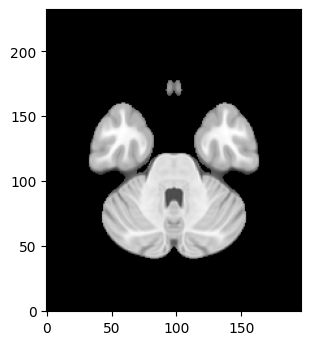

In [59]:
# Plot slice 40 (axial view). We transpose the image and set origin to lower, to see the axial representation
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(data[:,:,40].T,cmap='gray', origin='lower')

# Manual segmentation: 

Direct inspection of the histogram

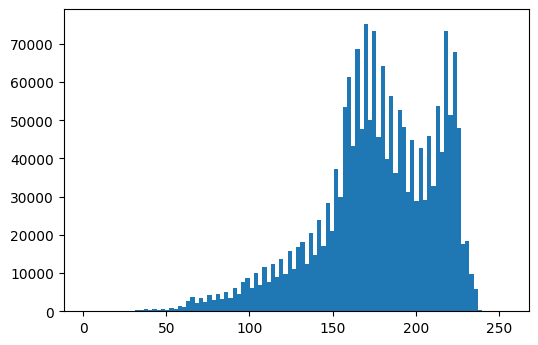

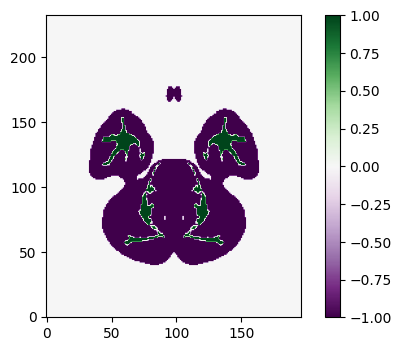

In [60]:
flat_data = data.flatten()
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

n = plt.hist(flat_data,bins=100,range=[1,flat_data.max()])
data_color = np.zeros(np.shape(data))
data_color[(data>200)] = 1
data_color[(data>50) & (data<200)] = -1
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(data_color[:,:,40].T,cmap='PRGn', origin='lower')
plt.colorbar()

# Otsu thresholding:
Optimal threshold separating background and foregraound structures

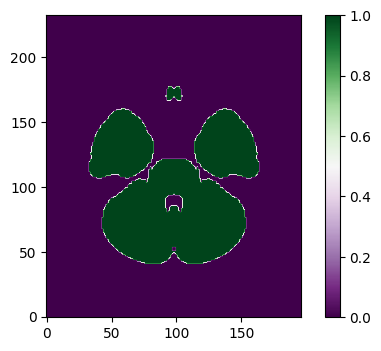

In [61]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

I = data[:,:,40].T
thresh = threshold_otsu(I)
binary = I > thresh

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
imgplot = plt.imshow(binary,cmap='PRGn', origin='lower')
plt.colorbar()

# Otsu multiple thresholds:

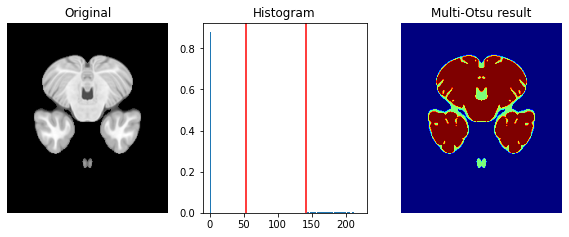

In [62]:
from skimage.filters import threshold_multiotsu

# Applying multi-Otsu threshold for the default value, generating
# three classes by default
thresholds = threshold_multiotsu(I)

# Using the threshold values, we generate the three regions.
regions = np.digitize(I, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(I.ravel(), bins=255,density=True)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

You can specify a larger number of classes: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  after removing the cwd from sys.path.


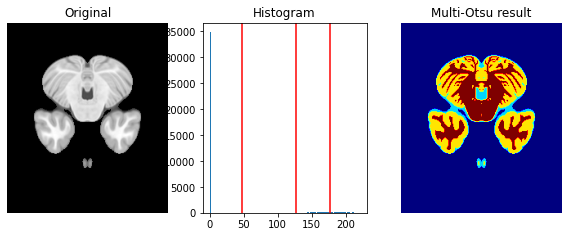

In [67]:
from skimage.color import label2rgb
thresholds = threshold_multiotsu(I, classes = 4)
regions = np.digitize(I, bins=thresholds)
regions_colorized = label2rgb(regions)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(I.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

# Gaussian Mixture Models - Clustering:

Cluster pixels using a weighted mixture of Gaussians

# $p(\vec{x}) = \sum_{i=1}^G \pi_i N(\vec{\mu_i},\Sigma)$
# $\sum_{i=1}^G \pi_i, 0\le \pi_i \le 1$

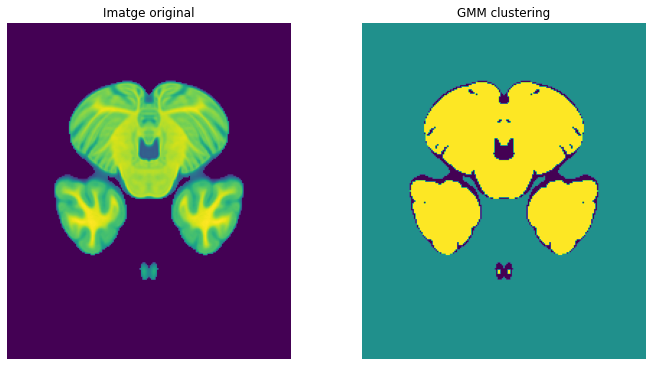

In [63]:
import skimage as sk # load skimage libraries
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import gridspec


v_I = np.reshape(I,(I.shape[0]*I.shape[1],1)) # reshape image as NPIX x NCHANNELS array
gmm = mixture.GaussianMixture(n_components=3).fit(v_I) # Fit a GMM model
v_gmm = gmm.fit_predict(v_I) # Predict GMM cluster labels for each pixel
I_segment = np.reshape(v_gmm,(I.shape[0],I.shape[1])) # reshape back to original image size

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I)
ax0.set_title('Imatge original')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_segment)
ax1.set_title('GMM clustering')
ax1.set_axis_off()

plt.tight_layout()
plt.show()

# GMM with model selection:
Determine the optimal number of clusters corresponding to different structures in the image. Use Bayesian Information Criterion as a parsimony index to choose 
the optimal model (Error vs Complexity tradeoff)

[523394.3463892296, -258966.70949776258, -262312.3835461194, -262476.8759145634, -262611.17107894184, -262671.90067738766, -262665.3012902599, -262557.0688535917, -262648.5299020667, -262643.27928554855]
...and the winner is GMM model G = 6


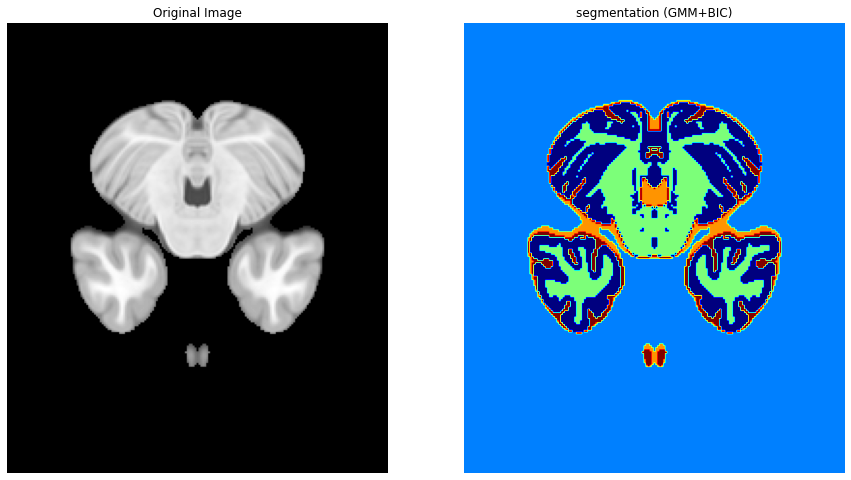

In [27]:
from skimage import io, exposure  
from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.measure import label
from skimage.transform import resize
from skimage.color import label2rgb, rgb2gray
import numpy as np
import skimage as sk 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import mixture

#Get BIC for each GMM 
NMAX = 10
bic = []
aic = []

for kG in np.arange(1,NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG).fit(v_I)
    bic.append(gmm.bic(v_I)) 
print(bic)

idx_winner = np.argmin(bic)
print('...and the winner is GMM model G = {}'.format(idx_winner+1))

gmmw = mixture.GaussianMixture(n_components=idx_winner).fit(v_I)
v_agg = gmmw.fit_predict(v_I)
I_gmm = np.array(v_agg).reshape(I.shape[0],I.shape[1])# Shape back result as image

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_gmm, cmap=plt.cm.jet)
ax2.set_title('segmentation (GMM+BIC)')
ax2.set_axis_off()

plt.show()

Segmentation using skimage libraries

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


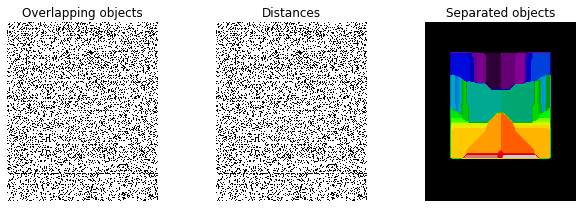

In [71]:
I = data[:,:,40].T

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(I)
I1 = np.int64(I)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=I1)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=I)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:488: RuntimeWarning: invalid value encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


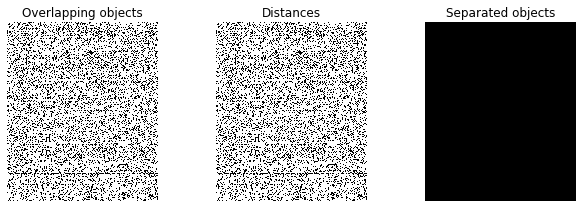

In [57]:

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(I, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [32]:
I.dtype

dtype('float64')

Segmentation using nilearn libraries